In [1]:
import math
import pandas as pd
from datetime import date, timedelta
import numpy as np
import matplotlib.dates as mdates
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import demeter
from demeter import (
    TokenInfo,
    Actuator,
    Strategy,
    ChainType,
    PeriodTrigger,
    realized_volatility,
    simple_moving_average,
    MarketInfo,
    RowData,
)
from demeter.uniswap import UniV3Pool, UniLpMarket
from demeter import PriceTrigger
from demeter.broker import  ActionTypeEnum
from demeter.uniswap.helper import tick_to_base_unit_price
import matplotlib.pyplot as plt 

def get_positions_info(actions, prices):
    positions = {}
    for action in actions:
        if action.action_type == ActionTypeEnum.uni_lp_add_liquidity:
            key = f'{action.position.lower_tick}_{action.position.upper_tick}'
            if key not in positions:
                positions[key] = {'start': action.timestamp}
        if action.action_type == ActionTypeEnum.uni_lp_remove_liquidity:
            key = f'{action.position.lower_tick}_{action.position.upper_tick}'
            if key in positions and action.remain_liquidity == 0:
                positions[key]['end'] = action.timestamp
    df_price = prices.copy(deep=True)
    df_price[eth.name] = df_price[eth.name].astype(float)
    df_price.plot(y=eth.name, kind='line', figsize=(20, 16))
    for key, position in positions.items():
        tick_lower, tick_upper = list(map(int, key.split('_')))
        price_upper = tick_to_base_unit_price(tick_lower, usdc.decimal, eth.decimal, market._is_token0_quote)
        price_lower = tick_to_base_unit_price(tick_upper, usdc.decimal, eth.decimal, market._is_token0_quote)
        if 'end' not in position:
            position['end'] = list(df_price.index)[-1]
        plt.fill_between([position['start'], position['end']], y1=price_lower, y2=price_upper, alpha=.25)
    plt.show()

c = 2


class BollingerPrice(Strategy):

    def initialize(self):
        """
        This function is called before main loop is executed.
        you can prepare data, or register trigger here
        """

        # Add a simple moving average line for backtesting data. In backtesting,
        # we will add/remove liquidity according to this line.
        self.add_column(
            market_key,
            "sma_1d",
            simple_moving_average(self.data[market_key].price, timedelta(hours=16)),
        )
        self.add_column(
            market_key,
            "volatility_1d",
            realized_volatility(self.data[market_key].price, timedelta(days=1), timedelta(days=1)),
        )
        # Register a trigger, every day, we split both assets into two shares of equal value
        self.current_lower_price = 2499
        self.current_upper_price = 2501

        # Register the PriceTrigger
        self.triggers.append(
            PriceTrigger(condition=self.is_price_out_of_range, do=self.handle_out_of_range_price)
        )

        self.markets.default.even_rebalance(self.data[market_key].iloc[0]["price"])

    def is_price_out_of_range(self, prices: pd.Series) -> bool:
        if self.current_lower_price is None or self.current_upper_price is None:
            return False
        current_price = prices[eth.name]
        return current_price < self.current_lower_price or current_price > self.current_upper_price

    def handle_out_of_range_price(self, row_data: RowData):
        # print(
        #     f"Price out of range. Current price: {row_data.prices[eth.name]}, Range: {self.current_lower_price} - {self.current_upper_price}"
        # )
        lp_market: UniLpMarket = self.broker.markets[market_key]

        # Remove all liquidity
        lp_market.remove_all_liquidity()

        # Recalculate the range and add liquidity again
        self.work(row_data)

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        lp_row_data = row_data.market_status[market_key]

        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()

        lp_market.even_rebalance(row_data.prices[eth.name])

        if math.isnan(lp_row_data.volatility_1d):
            return

        limit = c * float(row_data.prices[eth.name]) * lp_row_data.volatility_1d

        self.current_lower_price = lp_row_data.sma_1d - limit*2
        self.current_upper_price = lp_row_data.sma_1d + limit*2

        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(self.current_lower_price , self.current_upper_price)
        else:
            lp_market.add_liquidity(self.current_lower_price, self.current_upper_price)


def plot_price_and_moving_averages(df, price_col, ma_cols, title='Price and Moving Averages'):
    """
    Plot price and moving averages from a DataFrame, with crossover indicators.
    
    :param df: pandas DataFrame with DatetimeIndex
    :param price_col: str, name of the price column
    :param ma_cols: list of str, names of the moving average columns
    :param title: str, title of the plot
    """
    plt.figure(figsize=(14, 7))

    # Plot the price
    plt.plot(df.index, df[price_col], label=price_col.capitalize())

    # Plot the moving averages
    for ma_col in ma_cols:
        plt.plot(df.index, df[ma_col], label=ma_col)

    # Find crossover points
    if len(ma_cols) == 2:
        crossovers = df.index[((df[ma_cols[0]] > df[ma_cols[1]]) & (df[ma_cols[0]].shift(1) <= df[ma_cols[1]].shift(1))) | 
                              ((df[ma_cols[0]] < df[ma_cols[1]]) & (df[ma_cols[0]].shift(1) >= df[ma_cols[1]].shift(1)))]
        
        # Plot vertical lines at crossover points
        for crossover in crossovers:
            plt.axvline(x=crossover, color='r', linestyle='--', alpha=0.5)

    # Improve x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)

    # Add legend
    plt.legend()

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_prices_and_volatilities(df, price_cols, volatility_cols, title='Prices and Volatilities'):
    """
    Plot multiple prices on primary y-axis and multiple volatilities on secondary y-axis.
    
    :param df: pandas DataFrame with DatetimeIndex
    :param price_cols: list of str, names of the price columns
    :param volatility_cols: list of str, names of the volatility columns
    :param title: str, title of the plot
    """
    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Color cycles for prices and volatilities
    price_colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(price_cols)))
    vol_colors = plt.cm.Oranges(np.linspace(0.4, 0.8, len(volatility_cols)))

    # Plot prices on primary y-axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    for i, price_col in enumerate(price_cols):
        ax1.plot(df.index, df[price_col], color=price_colors[i], label=price_col)
    ax1.tick_params(axis='y')

    # Create secondary y-axis and plot volatilities
    ax2 = ax1.twinx()
    ax2.set_ylabel('Volatility')
    for i, vol_col in enumerate(volatility_cols):
        ax2.plot(df.index, df[vol_col], color=vol_colors[i], label=vol_col, linestyle='--')
    ax2.tick_params(axis='y')

    # Improve x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # Add title
    plt.title(title)

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.1, 1))

    # Add grid for better readability
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

In [2]:


if __name__ == "__main__":
    demeter.Formats.global_num_format = ".4g"  # change out put formats here

    usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
    eth = TokenInfo(name="eth", decimal=18)  # declare token1
    pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
    market_key = MarketInfo("lp")

    actuator = Actuator()  # declare actuator
    broker = actuator.broker
    market = UniLpMarket(market_key, pool)

    broker.add_market(market)
    broker.set_balance(usdc, 5000)
    broker.set_balance(eth, 0)

    actuator.strategy = BollingerPrice()
    market.data_path = "/Users/gnapsamuel/Documents/AMM/demeter-fetch/sample-data"
    market.load_data(
        ChainType.ethereum.name,
        "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
        date(2023, 1, 1),
        date(2024, 10, 1),
    )
    actuator.set_price(market.get_price_from_data())
    actuator.run()  # run test


2024-10-16 09:18:45,596 - INFO - start load files from 2023-01-01 to 2024-10-01...
2024-10-16 09:19:02,443 - INFO - load file complete, preparing...
2024-10-16 09:19:12,305 - INFO - data has been prepared
2024-10-16 09:19:12,783 - INFO - Quote token is USDC
2024-10-16 09:19:12,783 - INFO - init strategy...
2024-10-16 09:19:22,970 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 921600/921600 [01:49<00:00, 8384.49it/s]
2024-10-16 09:21:12,915 - INFO - main loop finished
2024-10-16 09:21:26,269 - INFO - Print actuator summary


Final account status                              
Token balance in broker       
USDC      :1764                     ETH       :0                        
Position value in markets     
lp(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick pending0 pending1        liquidity
0      195270      200840    147.9  0.05911  383505917642261

Quote by: USDC
Account balance history                           


2024-10-16 09:21:28,760 - INFO - Backtesting finished, execute time 136.0119969844818s


l1                  net_value tokens              lp                   \
l2                              USDC   ETH net_value base_uncollected   
2023-01-01 00:00:00      4999   2499  2.09         0                0   
2023-01-01 00:01:00      4999   2499  2.09         0                0   
2023-01-01 00:02:00      4998   2499 2.091         0                0   
2023-01-01 00:03:00      4998   2499 2.091         0                0   
2023-01-01 00:04:00      4998   2499 2.091         0                0   
...                       ...    ...   ...       ...              ...   
2024-10-01 23:55:00      6992   1764     0      5228          0.05911   
2024-10-01 23:56:00      6989   1764     0      5226          0.05911   
2024-10-01 23:57:00      6989   1764     0      5225          0.05911   
2024-10-01 23:58:00      6989   1764     0      5225          0.05911   
2024-10-01 23:59:00      6988   1764     0      5224          0.05911   

l1                                                

In [3]:
actuator._account_status_df.head(2)

l1                                              net_value  \
l2                                                          
2023-01-01 00:00:00  4998.7496871091991161608627190334096   
2023-01-01 00:01:00  4998.7496871091991161608627190334096   

l1                                                 tokens  \
l2                                                   USDC   
2023-01-01 00:00:00  2499.3748435545995580804313595167048   
2023-01-01 00:01:00  2499.3748435545995580804313595167048   

l1                                                               lp  \
l2                                                    ETH net_value   
2023-01-01 00:00:00  2.0903835994855007411546953190998956     0E-31   
2023-01-01 00:01:00  2.0903835994855007411546953190998956     0E-31   

l1                                                                       \
l2                  base_uncollected quote_uncollected base_in_position   
2023-01-01 00:00:00                0                 0                0   
2023-01-01 00:01:00                0                 0                0   

l1                                                    \
l2                  quote_in_position position_count   
2023-01-01 00:00:00                 0              0   
2023-01-01 00:01:00                 0              0   

l1                                                  price       
l2                                                    ETH USDC  
2023-01-01 00:00:00  1195.6536801043418491848942251691589    1  
2023-01-01 00:01:00  1195.6536801043418491848942251691589    1

In [4]:
actuator._account_status_df.shape

(921600, 11)

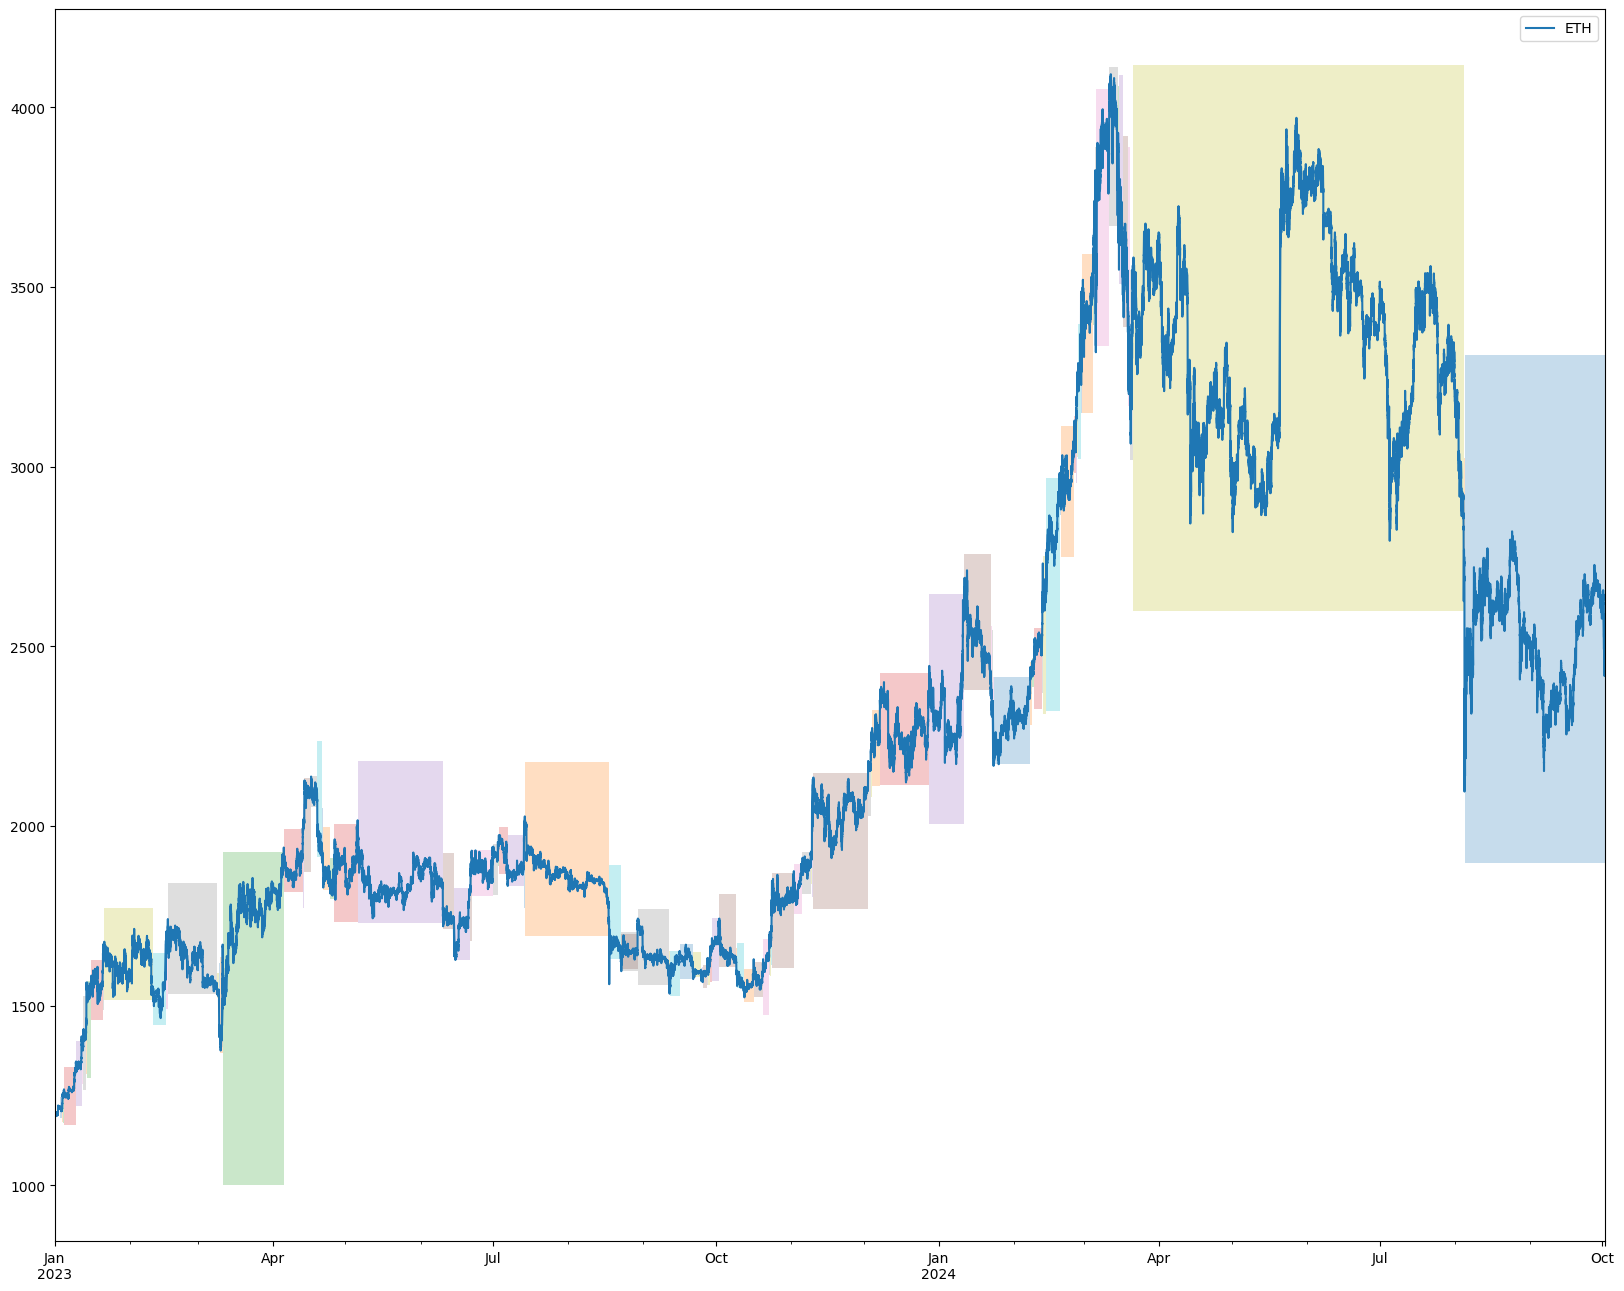

In [5]:
get_positions_info(actuator.actions, actuator.token_prices)

In [10]:
from demeter.result import performance_metrics
print({k: v for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["USDC"]
).items()})


{Start period: Timestamp('2023-01-01 00:00:00'), End period: Timestamp('2024-10-01 23:59:00'), Duration: Timedelta('640 days 00:00:00'), Return: 1989.28193872657, Rate of Return: 0.39795590162406813, APR: 0.21053331370541395, Max Draw Down: 0.28512423140307763, Sharpe Ratio: 0.6601586222456095, Volatility: 0.2734695990052651, Alpha: nan, Beta: nan, Benchmark return rate: 0.0, Benchmark APR: 0.0}


/Users/gnapsamuel/Documents/AMM/demeter/demeter/result/metrics/calculator.py:192: RuntimeWarning: invalid value encountered in scalar divide
  beta = cov[0, 1] / cov[1, 1]


In [11]:
actuator.account_status_df

l1                                              net_value  \
l2                                                          
2023-01-01 00:00:00  4998.7496871091991161608627190334096   
2023-01-01 00:01:00  4998.7496871091991161608627190334096   
2023-01-01 00:02:00  4997.9998371311153959265298658088415   
2023-01-01 00:03:00  4997.9998371310919572521170445031649   
2023-01-01 00:04:00  4997.9998371310919572521170445031648   
...                                                   ...   
2024-10-01 23:55:00  6991.6611636889997095274261331356120   
2024-10-01 23:56:00  6989.4289060988273569190798294143214   
2024-10-01 23:57:00  6989.1493553684574913594547102372404   
2024-10-01 23:58:00  6989.1497069730538990923572881888296   
2024-10-01 23:59:00  6988.0316258357686871153686704338285   

l1                                                 tokens  \
l2                                                   USDC   
2023-01-01 00:00:00  2499.3748435545995580804313595167048   
2023-01-01 00:01:00  2499.3748435545995580804313595167048   
2023-01-01 00:02:00  2498.9999185186920684748287322040923   
2023-01-01 00:03:00  2498.9999185655459786260585222515825   
2023-01-01 00:04:00  2498.9999185655459786260585222515824   
...                                                   ...   
2024-10-01 23:55:00  1763.7633512289846122652467384766101   
2024-10-01 23:56:00  1763.7633512289846122652467384766101   
2024-10-01 23:57:00  1763.7633512289846122652467384766101   
2024-10-01 23:58:00  1763.7633512289846122652467384766101   
2024-10-01 23:59:00  1763.7633512289846122652467384766101   

l1                                                         \
l2                                                    ETH   
2023-01-01 00:00:00  2.0903835994855007411546953190998956   
2023-01-01 00:01:00  2.0903835994855007411546953190998956   
2023-01-01 00:02:00  2.0906971100045929772890887927203626   
2023-01-01 00:03:00  2.0906971099653747536370982395050860   
2023-01-01 00:04:00  2.0906971099653747536370982395050860   
...                                                   ...   
2024-10-01 23:55:00                                     0   
2024-10-01 23:56:00                                     0   
2024-10-01 23:57:00                                     0   
2024-10-01 23:58:00                                     0   
2024-10-01 23:59:00                                     0   

l1                                                     lp  \
l2                                              net_value   
2023-01-01 00:00:00                                 0E-31   
2023-01-01 00:01:00                                 0E-31   
2023-01-01 00:02:00                                 0E-31   
2023-01-01 00:03:00                                 0E-31   
2023-01-01 00:04:00                                 0E-31   
...                                                   ...   
2024-10-01 23:55:00  5227.8978124600150972621793946590019   
2024-10-01 23:56:00  5225.6655548698427446538330909377113   
2024-10-01 23:57:00  5225.3860041394728790942079717606303   
2024-10-01 23:58:00  5225.3863557440692868271105497122195   
2024-10-01 23:59:00  5224.2682746067840748501219319572184   

l1                                                           \
l2                                         base_uncollected   
2023-01-01 00:00:00                                       0   
2023-01-01 00:01:00                                       0   
2023-01-01 00:02:00                                       0   
2023-01-01 00:03:00                                       0   
2023-01-01 00:04:00                                       0   
...                                                     ...   
2024-10-01 23:55:00  0.059108984600491469741161136507721239   
2024-10-01 23:56:00  0.059110538915557843980921539224405534   
2024-10-01 23:57:00  0.059110633726229765835152549339107167   
2024-10-01 23:58:00  0.059110733775569727919743323242780104   
2024-10-01 23:59:00  0.059111480155680762891210481522946597   

l1  

In [ ]:
# what we want is a combination of width and skew
# wider up the range when the volatility is high and skew the range towards where the volume flows 
# skewness could be determined by moving average simple thing 
# width needs to be some kind of combination of 

In [8]:
actuator.account_status_df["net_value"]

2023-01-01 00:00:00    4998.7496871091991161608627190334096
2023-01-01 00:01:00    4998.7496871091991161608627190334096
2023-01-01 00:02:00    4997.9998371311153959265298658088415
2023-01-01 00:03:00    4997.9998371310919572521170445031649
2023-01-01 00:04:00    4997.9998371310919572521170445031648
                                       ...                 
2024-10-01 23:55:00    6991.6611636889997095274261331356120
2024-10-01 23:56:00    6989.4289060988273569190798294143214
2024-10-01 23:57:00    6989.1493553684574913594547102372404
2024-10-01 23:58:00    6989.1497069730538990923572881888296
2024-10-01 23:59:00    6988.0316258357686871153686704338285
Name: net_value, Length: 921600, dtype: object

In [9]:
actuator.account_status_df["price"]["ETH"]

2023-01-01 00:00:00    1195.6536801043418491848942251691589
2023-01-01 00:01:00    1195.6536801043418491848942251691589
2023-01-01 00:02:00    1195.2950557275766093190726471935024
2023-01-01 00:03:00    1195.2950557275766093190726471935024
2023-01-01 00:04:00    1195.2950557275766093190726471935024
                                       ...                 
2024-10-01 23:55:00    2452.1302482714785769446849850867194
2024-10-01 23:56:00    2450.1694265455760429043679145275127
2024-10-01 23:57:00    2449.9244341021658263217357409534168
2024-10-01 23:58:00    2449.9244341021658263217357409534168
2024-10-01 23:59:00    2448.9447092719784548895138010447659
Name: ETH, Length: 921600, dtype: object

In [29]:
pd.read_csv("/Users/gnapsamuel/Documents/AMM/demeter-fetch/sample-data/ethereum-0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-2024-03-18.minute.csv")

,timestamp,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity
0,2024-03-18 00:00:00,-239051751012,65707898731174219732,194327.0,194317.0,194317.0,194327.0,0,65707898731174219732,7750102749641163308
1,2024-03-18 00:01:00,-156725469626,43136280628377339304,194334.0,194327.0,194327.0,194337.0,75281802774,63835056643936987721,7750130571291231460
2,2024-03-18 00:02:00,-139715809828,38485365535000161127,194340.0,194339.0,194335.0,194340.0,90108162425,63264263647759350166,7750143498254540827
3,2024-03-18 00:03:00,-82660226587,22768734709315811115,194344.0,194344.0,194344.0,194344.0,12451265726,26195184945097588736,7750143498254540827
4,2024-03-18 00:04:00,5603367475,-1541925010743938681,194343.0,194343.0,194343.0,194343.0,5603367475,0,7750143498254540827
...,...,...,...,...,...,...,...,...,...,...
1435,2024-03-18 23:55:00,-132051918331,37494537412989984461,194648.0,194648.0,194648.0,194648.0,0,37494537412989984461,15224833653431197994
1436,2024-03-18 23:56:00,-87416407514,24947229301407150069,194650.0,194648.0,194648.0,194655.0,423882586614,145245982317568757509,15373544763770261541
1437,2024-03-18 23:57:00,-257484453053,73155949569494465623,194656.0,194650.0,194650.0,194656.0,3218329374,74069148079402693145,15373544763770261541
1438,2024-03-18 23:58:00,79733319,-22552167923236165,194656.0,194656.0,194656.0,194656.0,378733319,84974136413802499,15373544763770261541


In [13]:
df = actuator._account_status_df[['price']]
df.columns = ['price', 'usdc']
df = df.drop(columns='usdc')

In [20]:
df['MA_50h'] = simple_moving_average(df.price, window=timedelta(hours=50))
df['MA_200h'] = simple_moving_average(df.price, window=timedelta(hours=200))

df['MA_5h'] = simple_moving_average(df.price, window=timedelta(hours=5))
df['MA_25h'] = simple_moving_average(df.price, window=timedelta(hours=25))

In [17]:
df.iloc[:200000]

,price,MA_50h,MA_200h,MA_5h,MA_20h
2023-01-01 00:00:00,1195.6536801043418491848942251691589,NaN,NaN,NaN,NaN
2023-01-01 00:01:00,1195.6536801043418491848942251691589,NaN,NaN,NaN,NaN
2023-01-01 00:02:00,1195.2950557275766093190726471935024,NaN,NaN,NaN,NaN
2023-01-01 00:03:00,1195.2950557275766093190726471935024,NaN,NaN,NaN,NaN
2023-01-01 00:04:00,1195.2950557275766093190726471935024,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-05-19 21:15:00,1813.5245551628993243299070762522419,1813.625472,1807.323558,1815.116932,1809.588104
2023-05-19 21:16:00,1813.7059076184156142623400669598689,1813.619274,1807.323316,1815.105435,1809.595491
2023-05-19 21:17:00,1813.5245551628993243299070762522419,1813.613077,1807.323119,1815.093333,1809.603028
2023-05-19 21:18:00,1813.5245551628993243299070762522419,1813.606880,1807.322817,1815.081232,1809.611017


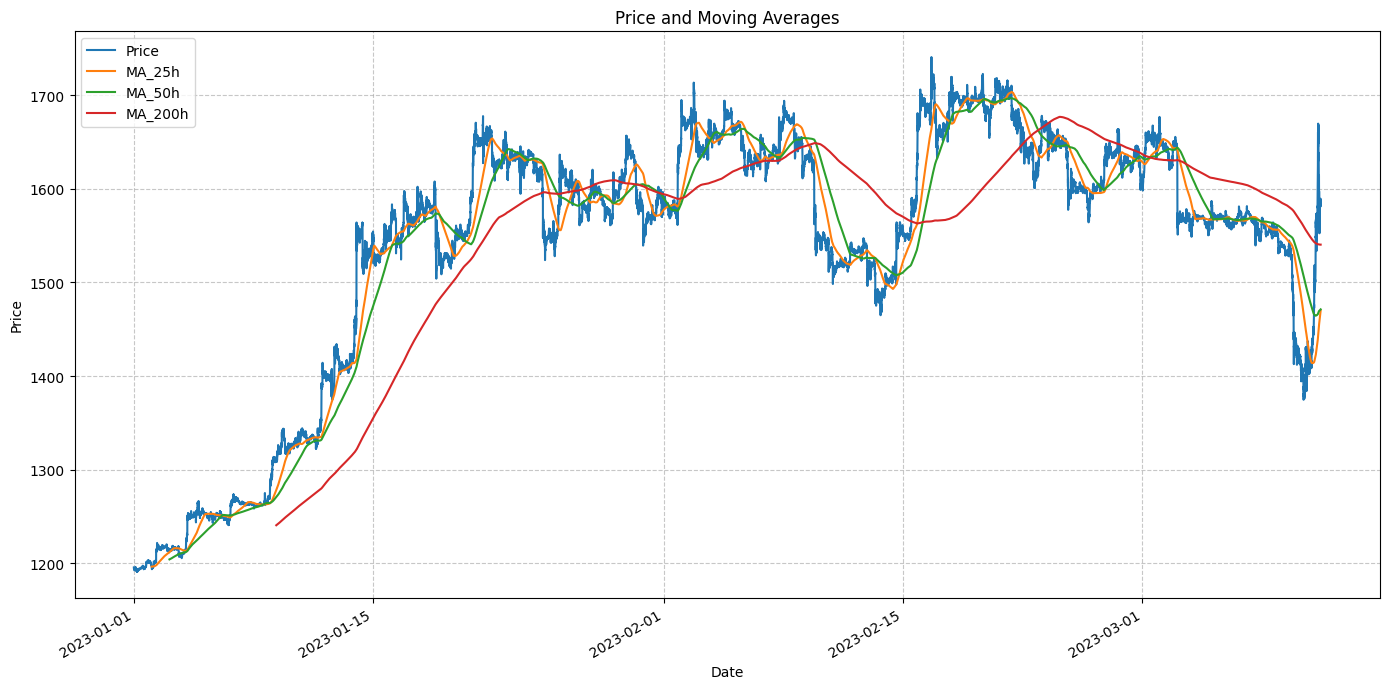

In [23]:
plot_price_and_moving_averages(df.iloc[:100000], 'price', ['MA_25h','MA_50h', 'MA_200h'])

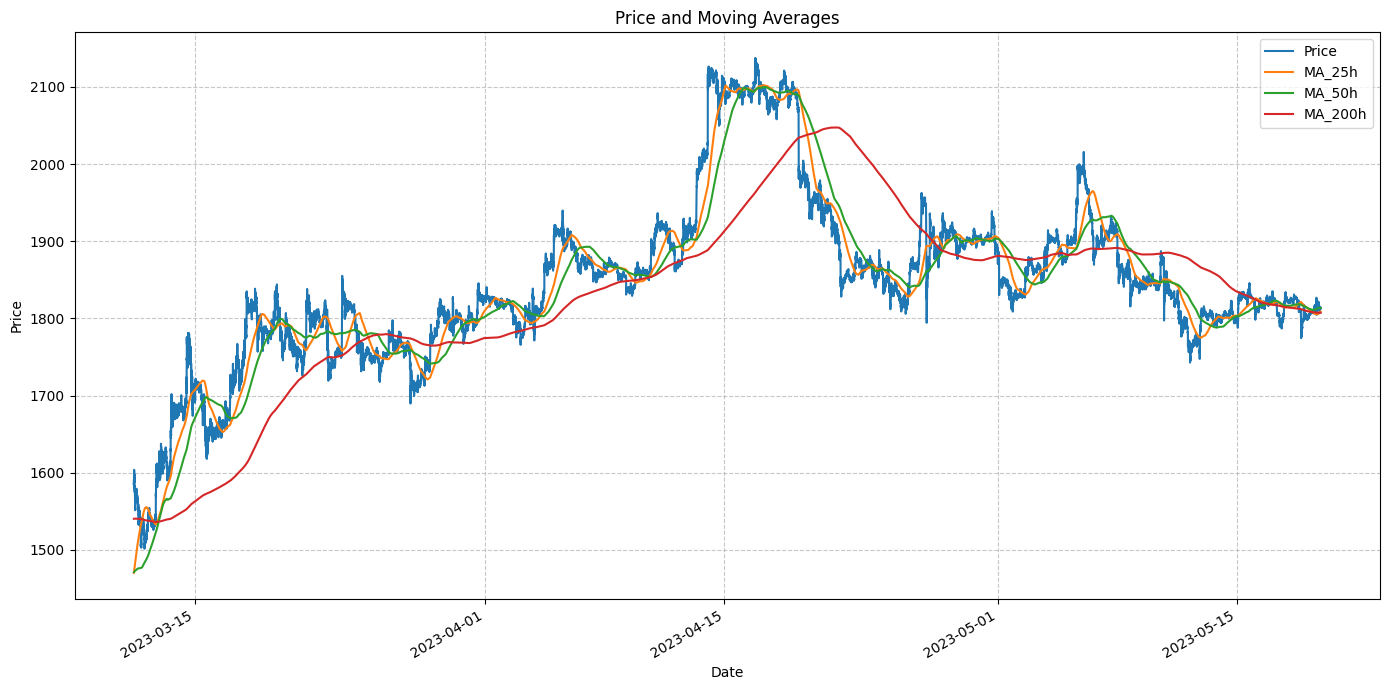

In [26]:
plot_price_and_moving_averages(df.iloc[100000:200000], 'price', ['MA_25h','MA_50h', 'MA_200h'])

In [15]:
df['vol_30h_30d'] = realized_volatility(df.price, timedelta(hours=8), timedelta(hours=240))
df['vol_7d_30d'] = realized_volatility(df.price, timedelta(days=7), timedelta(days=30))

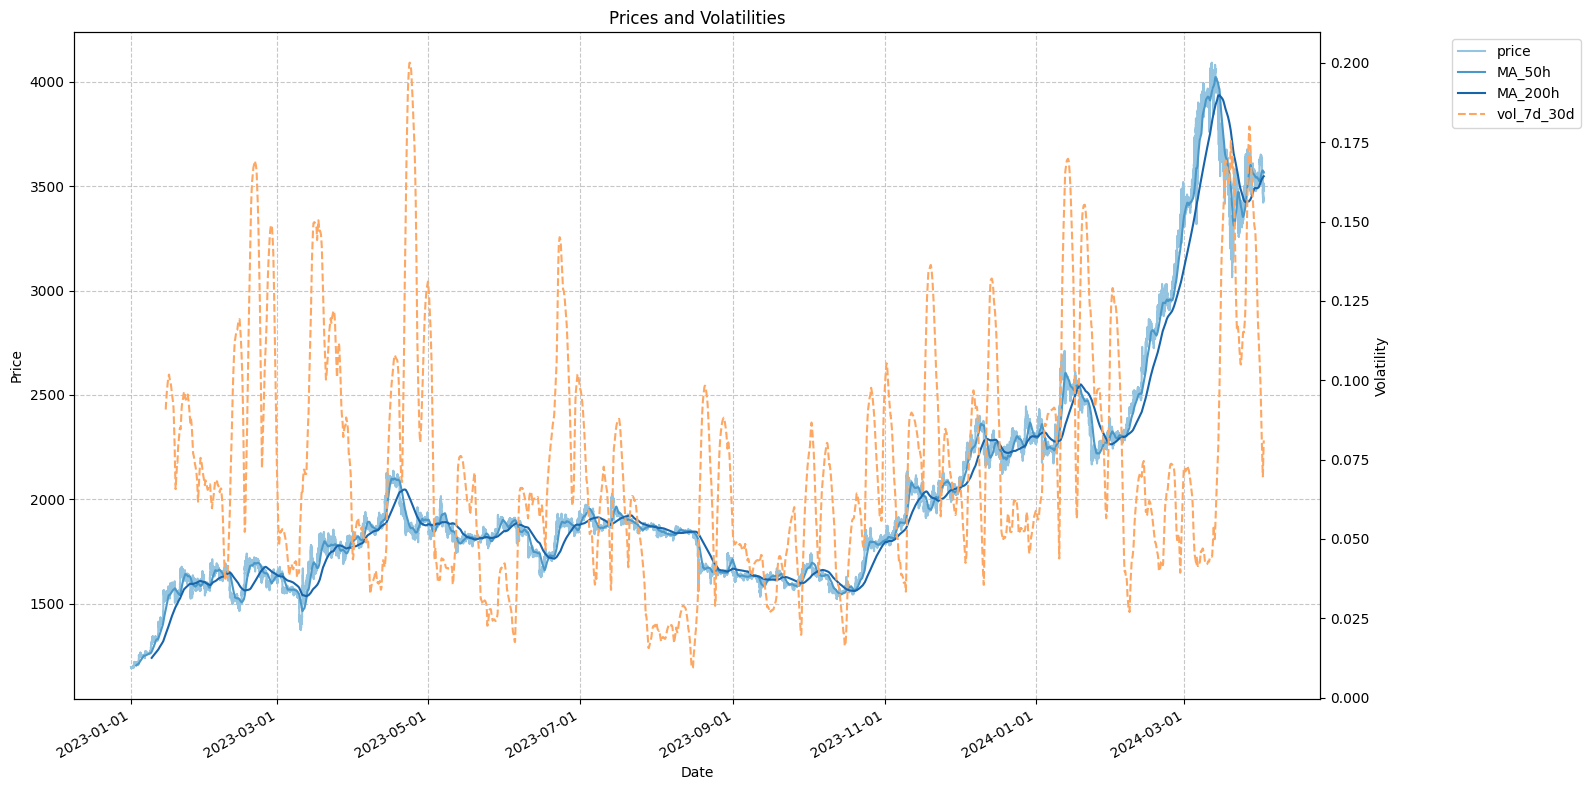

In [31]:
plot_prices_and_volatilities(df, 
                             price_cols=['price', 'MA_50h', 'MA_200h'],
                             volatility_cols=['vol_7d_30d'])

In [18]:
def calculate_rv_components(df, price_col='price'):
    """Calculate daily, weekly, and monthly realized volatilities."""
    # Daily RV (1 day window)
    df['RV_d'] = realized_volatility(df[price_col], timedelta(days=1), timedelta(days=1))
    
    # Weekly RV (7 day window)
    df['RV_w'] = realized_volatility(df[price_col], timedelta(days=7), timedelta(days=7))
    
    # Monthly RV (30 day window)
    df['RV_m'] = realized_volatility(df[price_col], timedelta(days=14), timedelta(days=14))
    
    return df

def fit_har_rv(df):
    """Fit the HAR-RV model."""
    y = df['RV_d'].shift(-1440)  # Next day's volatility
    X = df[['RV_d', 'RV_w', 'RV_m']]
    X = sm.add_constant(X)
    
    # Remove NaN values
    valid = ~(y.isnull() | X.isnull().any(axis=1))
    y = y[valid]
    X = X[valid]
    
    model = OLS(y, X).fit()
    return model

def forecast_har_rv_vectorized(model, df):
    """Forecast volatility using the HAR-RV model in a vectorized manner."""
    X = sm.add_constant(df[['RV_d', 'RV_w', 'RV_m']])
    return model.predict(X)

In [19]:
df = calculate_rv_components(df)

In [20]:
har_model = fit_har_rv(df)

In [21]:
df['HAR_RV_forecast'] = np.nan
forecast_start = 30 * 1440  # Assuming we need at least 30 days of data for the monthly component
df.loc[df.index[forecast_start:], 'HAR_RV_forecast'] = forecast_har_rv_vectorized(
    har_model, 
    df.iloc[forecast_start-1:-1]  # Use data up to the second-to-last row to forecast
)

In [24]:
df.iloc[forecast_start-1:-1]

,price,MA_50h,MA_200h,MA_5h,MA_20h,vol_30h_30d,vol_7d_30d,RV_d,RV_w,RV_m,HAR_RV_forecast
2023-01-30 23:59:00,1566.3992975831190528986191023223983,1603.302581,1600.986839,1556.970073,1589.724404,0.035986,0.068414,0.030951,0.033047,0.083626,NaN
2023-01-31 00:00:00,1566.2426733157874741512039819242046,1603.302476,1600.980968,1556.932349,1589.664331,0.035892,0.068416,0.030938,0.033048,0.083632,0.022961
2023-01-31 00:01:00,1566.7125931066286525403893551290526,1603.302633,1600.975150,1556.896192,1589.604514,0.035798,0.068416,0.030924,0.033048,0.083639,0.022954
2023-01-31 00:02:00,1566.3992975831190528986191023223983,1603.302685,1600.969320,1556.859516,1589.544435,0.035703,0.068417,0.030909,0.033049,0.083645,0.022947
2023-01-31 00:03:00,1566.3992975831190528986191023223983,1603.302998,1600.963653,1556.829671,1589.484357,0.035598,0.068418,0.030894,0.033049,0.083651,0.022939
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01 23:54:00,3506.2225348217729277140582755069478,3565.766594,3547.543694,3490.759698,3517.753418,0.067424,0.081000,0.026312,0.039127,0.053750,0.019833
2024-04-01 23:55:00,3505.8719476270102266913891365932863,3565.766711,3547.552470,3490.955526,3517.664147,0.067867,0.081011,0.026274,0.039132,0.053752,0.019814
2024-04-01 23:56:00,3505.8719476270102266913891365932863,3565.766360,3547.561331,3491.151354,3517.575177,0.068358,0.081022,0.026235,0.039137,0.053754,0.019795
2024-04-01 23:57:00,3505.8719476270102266913891365932863,3565.766010,3547.570390,3491.350629,3517.486507,0.068865,0.081033,0.026197,0.039143,0.053756,0.019775


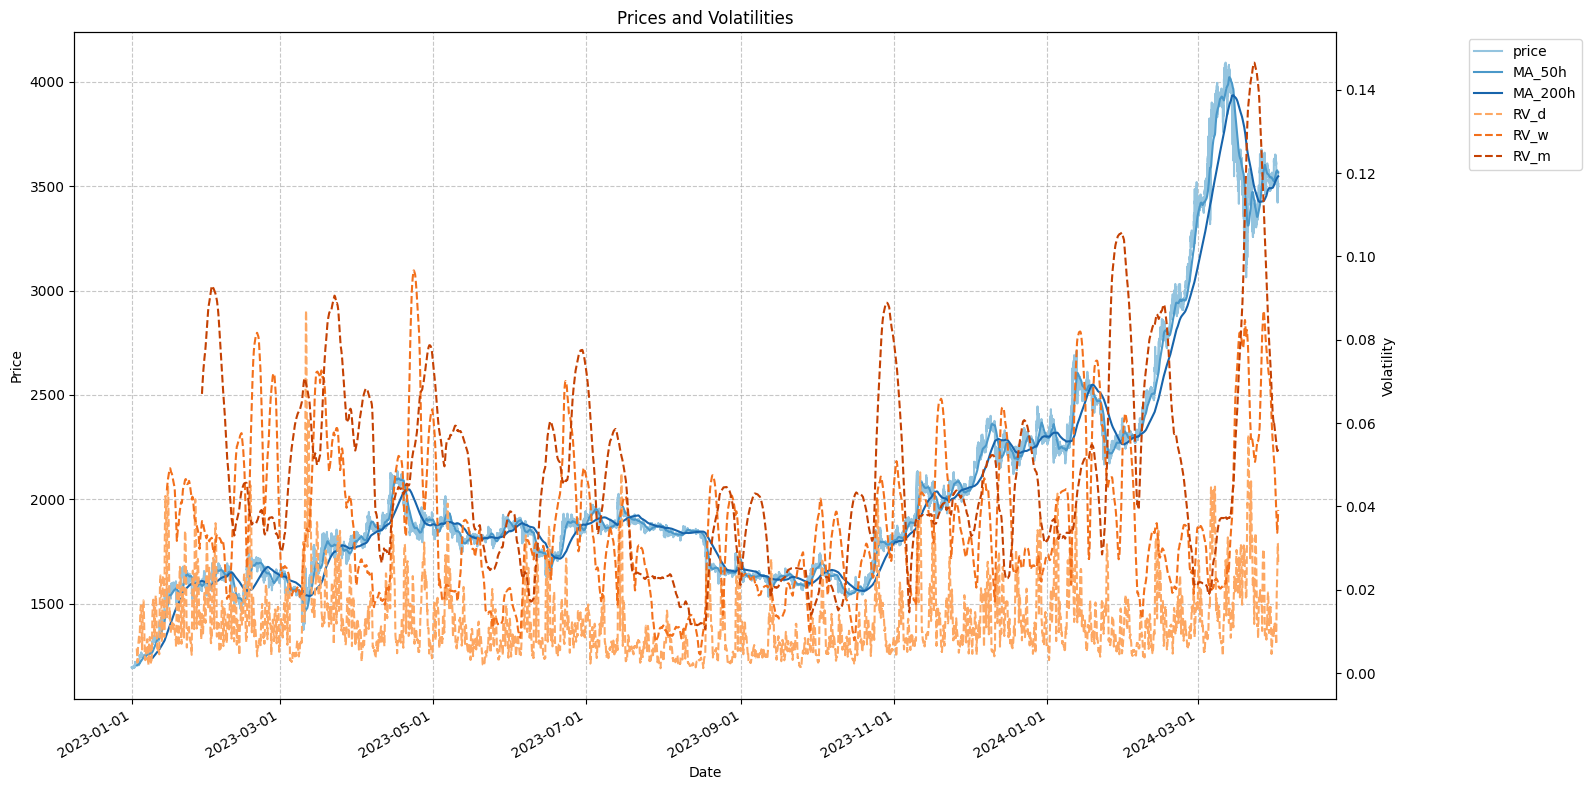

In [25]:
plot_prices_and_volatilities(df, 
                             price_cols=['price', 'MA_50h', 'MA_200h'],
                             volatility_cols=['RV_d', 'RV_w','RV_m'])

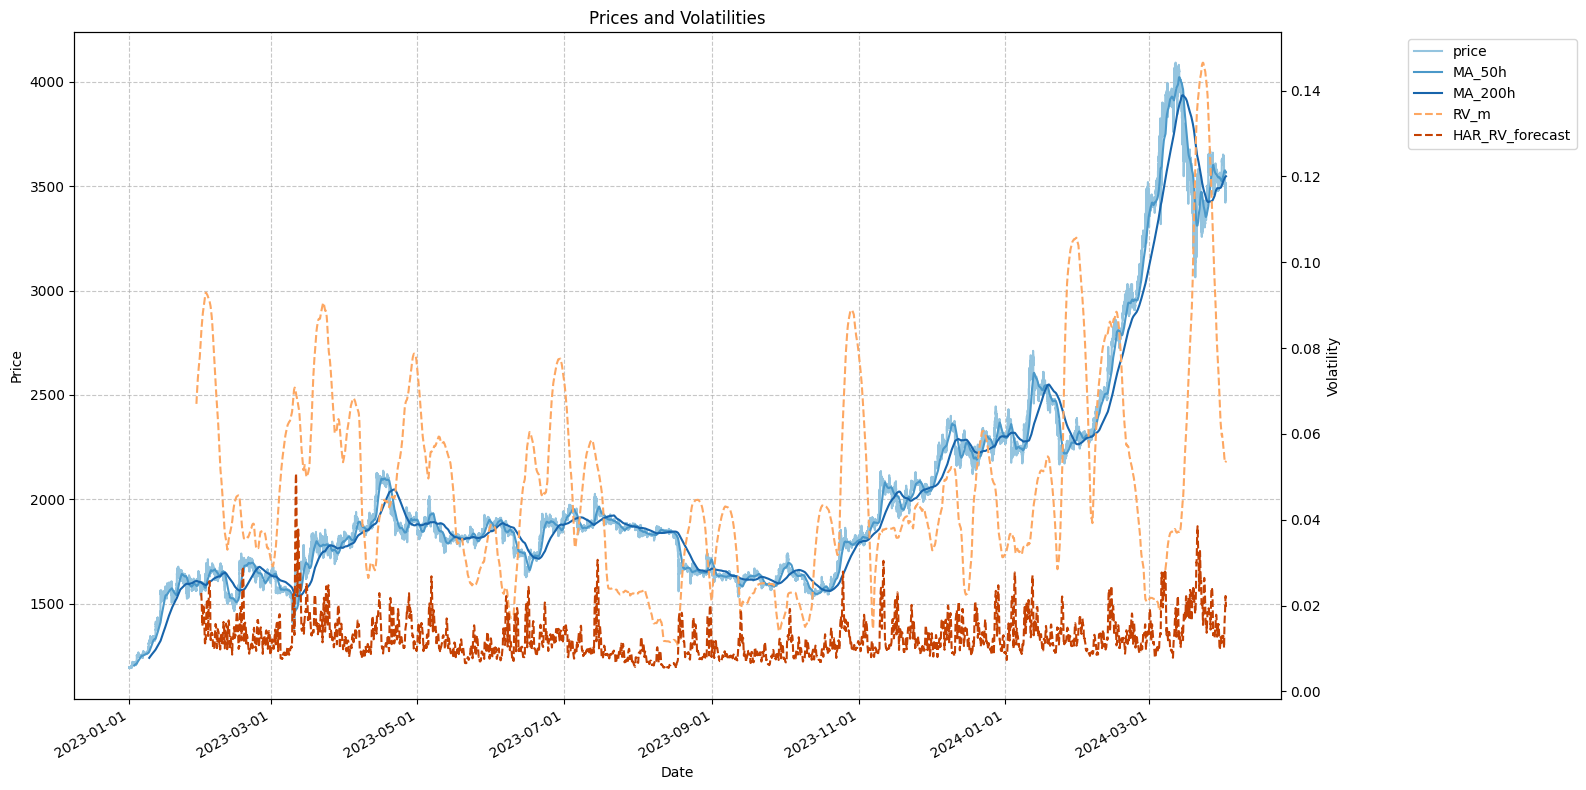

In [27]:
plot_prices_and_volatilities(df, 
                             price_cols=['price', 'MA_50h', 'MA_200h'],
                             volatility_cols=['RV_m', 'HAR_RV_forecast'])